# Cat vs. Dog Image Classification

In this exercise, we will load some pretrained classifier models and train them to distinguish dogs from cats. We will follow these steps:

1. Explore the example data
2. Load Convolutional Neural Network to solve our classification problem
3. Train the model
4. Evaluate training and validation accuracy
5. Predict a new image loaded from your computer

Let's go!

## Explore and arrange the Data 

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-05-27 14:54:26--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   244MB/s    in 0.3s    

2022-05-27 14:54:26 (244 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets, which in turn each contain `cats` and `dogs` subdirectories. Let's define each of these directories:

In [2]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp') #Extract zip files
zip_ref.close()

In [3]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_cat_fnames.sort()
train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

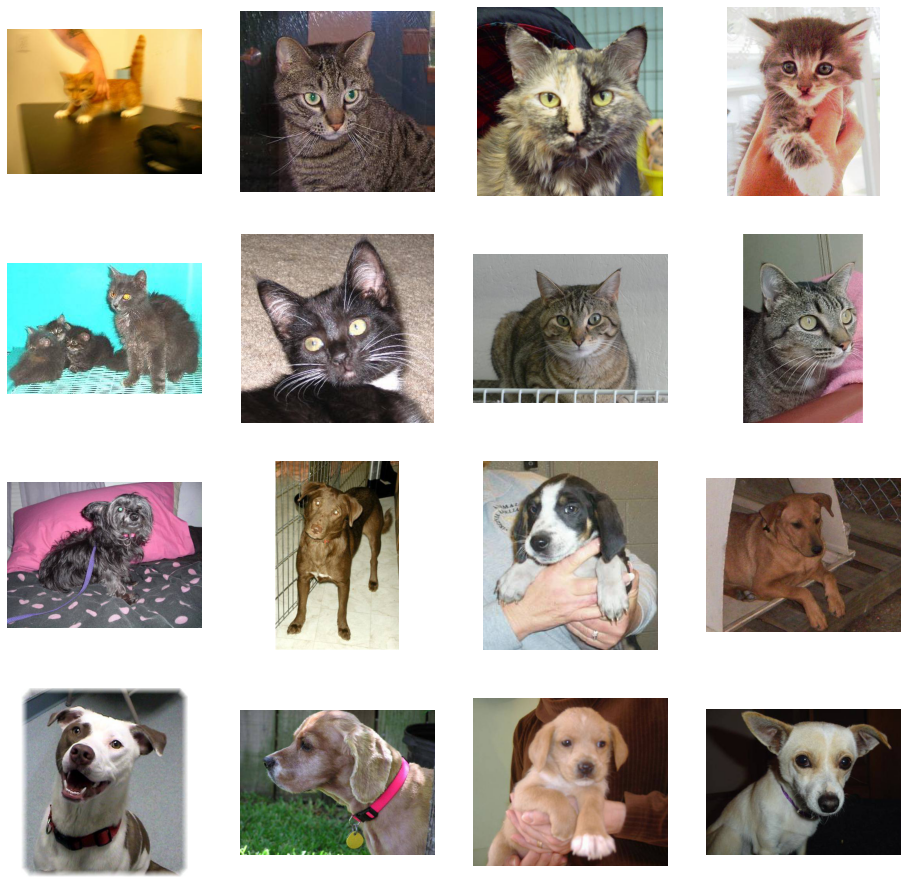

In [5]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [6]:
from torchvision.transforms.transforms import CenterCrop
import torch
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

class CatDogDataset(Dataset):
    
    def __init__(self, mode = "train", transforms = None):     
        super().__init__()
        self.mode = mode
        self.transforms = transforms
        if self.mode == "train":
          cats_dir = train_cats_dir
          dogs_dir = train_dogs_dir
          self.main_dir = train_dir
        else:
          cats_dir = validation_cats_dir
          dogs_dir = validation_dogs_dir
          self.main_dir = validation_dir
        cat_fnames = [f"cats/{fn}" for fn in os.listdir(cats_dir)]
        dog_fnames = [f"dogs/{fn}" for fn in os.listdir(dogs_dir)]
        if self.mode == "val":
          cat_fnames = cat_fnames[:300]
          dog_fnames = dog_fnames[:300]
        elif self.mode == "test":
          cat_fnames = cat_fnames[300:]
          dog_fnames = dog_fnames[300:]
        self.img_names = cat_fnames + dog_fnames
        
    def __getitem__(self, idx):
        
        image_name = self.img_names[idx]
        img = Image.open(os.path.join(self.main_dir, image_name))
        img = img.resize((224, 224))
        
        if self.mode == "train" or self.mode == "val":
            ### Preparing class label
            if idx < [1000, 300][self.mode == "val"]:
              label = 0
            else:
              label = 1
            
            label = torch.tensor(label, dtype = torch.float32)

            ### Apply Transforms on image
            img = self.transforms(img)

            return img, label
        
        elif self.mode == "test":
            
            ### Apply Transforms on image
            img = self.transforms(img)

            return img 
        
    def __len__(self):
        return len(self.img_names)

def get_train_transform():
    return T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(15),
        T.RandomCrop(204),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std= [0.229, 0.224, 0.225])
    ])
    
def get_val_transform():
    return T.Compose([
        # T.CenterCrop(204),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std= [0.229, 0.224, 0.225])
    ])
    

In [7]:
train_dataset = CatDogDataset(mode = "train", transforms = get_train_transform())
val_dataset = CatDogDataset(mode = "val", transforms = get_val_transform())
test_dataset = CatDogDataset(mode = "test", transforms = get_val_transform())

train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 4,
    batch_size = 16,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = 4,
    batch_size = 16,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    num_workers = 4,
    batch_size = 16,
    shuffle = True
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.])


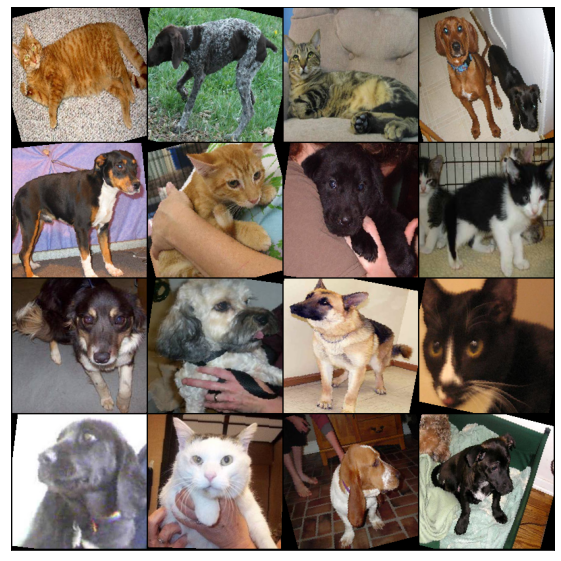

In [8]:
from torchvision.utils import make_grid

for images, labels in train_data_loader:
    
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    print(labels)
    break

## Loading a CNN for our classification problem

The torchvision.models subpackage contains definitions of models for addressing different tasks, including: image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection, video classification, and optical flow.
Several pre-trained Deep Convolutional Neural Network (*resnet18, resnet50, DenseNet, ConvNeXt*) are explored to predict Cats images versus Dogs ones.



The images that will go into our convnet are 150x150 color images (in the next section on Data Preprocessing, we'll add handling to resize all the images to 150x150 before feeding them into the neural network).


In [56]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, resnet50, convnext_base 
from torchvision.models.convnext import LayerNorm2d
from functools import partial

models = {
    "resnet18": resnet18(pretrained = True), 
    "resnet50": resnet50(pretrained = True),
    "convnext_base": convnext_base(pretrained = True)
}

last_layer_dimension = {
    "resnet18": 512, 
    "resnet50": 2048,
    "convnext_base": 1024
}

model_name = "convnext_base"
model = models[model_name]

# Modifying Head - classifier
if "resnet" in model_name:
  model.fc = nn.Sequential(
      nn.Linear(last_layer_dimension[model_name], 1, bias = True),
      nn.Sigmoid()
  )
else:
  norm_layer = partial(LayerNorm2d, eps=1e-6)
  model.classifier = nn.Sequential(
      norm_layer(last_layer_dimension[model_name]), 
      nn.Flatten(1),
      nn.Linear(last_layer_dimension[model_name], 1, bias = True),
      nn.Sigmoid()
  )


Check on which device we are handling the neural network. GPU helps to perform the training on large and complex datasets with ease as compared to CPU. So availability of GPU gives advantage on faster training of the model.

In [57]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [58]:
from torchsummary import summary

model.to(device)
summary(model, (3, 204, 204))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 51, 51]           6,272
       LayerNorm2d-2          [-1, 128, 51, 51]             256
            Conv2d-3          [-1, 128, 51, 51]           6,400
           Permute-4          [-1, 51, 51, 128]               0
         LayerNorm-5          [-1, 51, 51, 128]             256
            Linear-6          [-1, 51, 51, 512]          66,048
              GELU-7          [-1, 51, 51, 512]               0
            Linear-8          [-1, 51, 51, 128]          65,664
           Permute-9          [-1, 128, 51, 51]               0
  StochasticDepth-10          [-1, 128, 51, 51]               0
          CNBlock-11          [-1, 128, 51, 51]               0
           Conv2d-12          [-1, 128, 51, 51]           6,400
          Permute-13          [-1, 51, 51, 128]               0
        LayerNorm-14          [-1, 51, 

## Train the Network

In [59]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

#Loss Function
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
model.to(device)

# No of epochs 
epochs = 10

In [62]:
import time
import numpy as np


def accuracy(preds, trues):
    
    ### Converting preds to 0 or 1
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    
    ### Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    
    ### Summing over all correct predictions
    acc = np.sum(acc) / len(preds)
    
    return (acc * 100)
    
    

def train_one_epoch(train_data_loader):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    model.to(device)
    ###Iterating over data loader
    for images, labels in train_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
        
        #Backward
        _loss.backward()
        optimizer.step()
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
        
    return epoch_loss, epoch_acc, total_time
      


def val_one_epoch(val_data_loader, best_val_acc):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in val_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)
    
    ###Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),f"{model_name}_best.pth")
        
    return epoch_loss, epoch_acc, total_time, best_val_acc
        

In [63]:
best_val_acc = 0
for epoch in range(epochs):
    
    ###Training
    loss, acc, _time = train_one_epoch(train_data_loader)
    
    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    ###Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, best_val_acc)
    
    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Training
Epoch 1
Loss : 0.0738
Acc : 97.45
Time : 103.2858

Validating
Epoch 1
Loss : 0.068
Acc : 97.5329
Time : 13.1408

Training
Epoch 2
Loss : 0.0187
Acc : 99.55
Time : 102.9885

Validating
Epoch 2
Loss : 0.0163
Acc : 99.5066
Time : 13.0592

Training
Epoch 3
Loss : 0.0214
Acc : 99.25
Time : 103.1707

Validating
Epoch 3
Loss : 0.0562
Acc : 97.8618
Time : 13.0297

Training
Epoch 4
Loss : 0.0091
Acc : 99.8
Time : 103.0181

Validating
Epoch 4
Loss : 0.015
Acc : 99.3421
Time : 13.0655

Training
Epoch 5
Loss : 0.01
Acc : 99.8
Time : 102.9913

Validating
Epoch 5
Loss : 0.0205
Acc : 99.0132
Time : 12.9895

Training
Epoch 6
Loss : 0.0156
Acc : 99.4
Time : 102.8972

Validating
Epoch 6
Loss : 0.0297
Acc : 99.0132
Time : 13.0221

Training
Epoch 7
Loss : 0.013
Acc : 99.65
Time : 103.0878

Validating
Epoch 7
Loss : 0.0189
Acc : 99.1776
Time : 13.0811

Training
Epoch 8
Loss : 0.0134
Acc : 99.65
Time : 103.0999

Validating
Epoch 8
Loss : 0.0261
Acc : 99.1776
Time : 12.9457

Training
Epoch 9
Loss :

## Evaluating training and validation accuracy

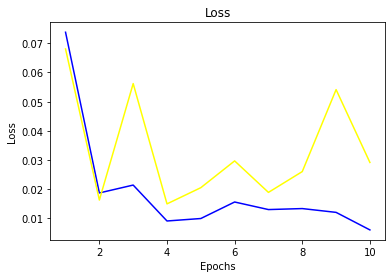

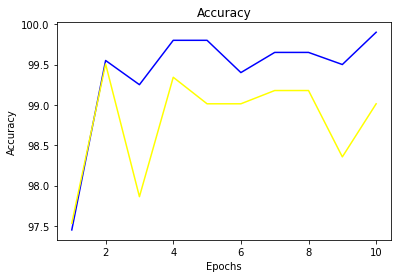

In [64]:
### Plotting Results

#Loss
plt.title("Loss")
plt.plot(np.arange(1, 11, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, 11, 1), val_logs["loss"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, 11, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, 11, 1), val_logs["accuracy"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


## Predict a new image loaded from your computer

In [90]:
#!wget https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Gatto_europeo4.jpg/220px-Gatto_europeo4.jpg
# !wget https://www.sbb.ch/content/dam/internet/sharedimages/personen/GA-Hund.jpg/_jcr_content/renditions/cq5dam.web.1280.1280.jpeg
# use !wget to download your image

--2022-05-27 16:18:36--  https://www.sbb.ch/content/dam/internet/sharedimages/personen/GA-Hund.jpg/_jcr_content/renditions/cq5dam.web.1280.1280.jpeg
Resolving www.sbb.ch (www.sbb.ch)... 194.150.245.142, 2a00:4bc0:ffff:9::c296:f58e
Connecting to www.sbb.ch (www.sbb.ch)|194.150.245.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180556 (176K) [image/jpeg]
Saving to: ‘cq5dam.web.1280.1280.jpeg’

cq5dam.web.1280.128 100%[===================>] 176.32K   608KB/s    in 0.3s    

2022-05-27 16:18:37 (608 KB/s) - ‘cq5dam.web.1280.1280.jpeg’ saved [180556/180556]



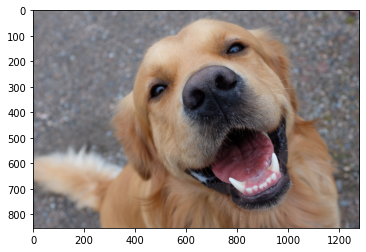

In [91]:
# name_file = "220px-Gatto_europeo4.jpg"
name_file = "cq5dam.web.1280.1280.jpeg"
img = mpimg.imread(name_file)
plt.imshow(img)
plt.show()

In [93]:
img = Image.open(name_file)
img = img.resize((224, 224))
transform = get_val_transform()
img = transform(img)
img = torch.unsqueeze(img, 0)
out = model(img.to(device))
print("It's a",["Cat!", "Dog!"][out > 0.5])

It's a Dog!


The Experiment is concluded! :)